# 24S2 SC3000/CZ3005 Assignment 1: Balancing a Pole on a Cart

## Importing dependencies and define helper functions

In [31]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import defaultdict

In [4]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [23]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [24]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [25]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [26]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([ 0.02275278,  0.02922267, -0.00081343, -0.04897029], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [27]:
observation, reward, terminated, truncated, info = env.step(0)
done = terminated or truncated  # Combine both termination conditions

print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02333724 -0.16588761 -0.00179284  0.24345587]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [28]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, terminated, truncated, info = env.step(0)
    done = terminated or truncated
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [15]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [28]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([ 0.00606912,  0.02743864,  0.03684267, -0.00440233], dtype=float32), {})
Chosen action: 0


In [80]:
# Q-learning parameters
alpha = 0.2  # Increased Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.001  # Slower decay rate for better exploration
epsilon_min = 0.05  # Minimum value of epsilon
num_episodes = 5000  # Increased training episodes

# Discretization of state space
def discretize_state(state, bins):
    cart_pos, cart_vel, pole_angle, pole_ang_vel = state
    cart_pos_bin = np.digitize(cart_pos, bins[0])
    cart_vel_bin = np.digitize(cart_vel, bins[1])
    pole_angle_bin = np.digitize(pole_angle, bins[2])
    pole_ang_vel_bin = np.digitize(pole_ang_vel, bins[3])
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_ang_vel_bin)

# Create finer bins for discretization
bins = [
    np.linspace(-4.8, 4.8, 20),  # Cart Position
    np.linspace(-4.0, 4.0, 20),  # Cart Velocity
    np.linspace(-0.418, 0.418, 20),  # Pole Angle
    np.linspace(-4.0, 4.0, 20)  # Pole Angular Velocity
]

# Initialize Q-table
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

# Q-learning training loop
for episode in range(num_episodes):
    state, _ = env.reset()
    state = discretize_state(state, bins)
    done = False
    total_reward = 0
    
    while not done:
        # Choose action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit best known action
        
        # Take action and observe new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_state, bins)
        done = terminated or truncated
        total_reward += reward
        
        # Update Q-value using Bellman equation
        q_table[state][action] = (q_table[state][action] + alpha * 
                                  (reward + gamma * np.max(q_table[next_state]) - q_table[state][action]))
        
        state = next_state  # Move to next state
    
    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

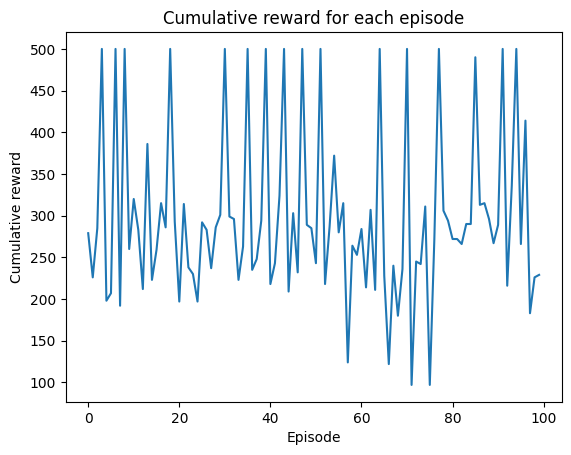

In [81]:
# Evaluate agent's performance
num_eval_episodes = 100
episode_results = []
for episode in range(num_eval_episodes):
    state, _ = env.reset()
    state = discretize_state(state, bins)
    done = False
    cumulative_reward = 0
    
    while not done:
        action = np.argmax(q_table[state])  # Always exploit the best known action
        state, reward, terminated, truncated, _ = env.step(action)
        state = discretize_state(state, bins)
        done = terminated or truncated
        cumulative_reward += reward
    
    episode_results.append(cumulative_reward)

# Plot results
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

Print the average reward over the 100 episodes.

In [82]:
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Average cumulative reward: 297.32
Is my agent good enough? True


## Testing All together *Can remove code below

In [3]:
# Q-learning parameters
alpha = 0.2  # Increased Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.999  # Slower decay rate for better exploration
epsilon_min = 0.05  # Minimum value of epsilon
num_episodes = 5000  # Increased training episodes

# Discretization of state space
def discretize_state(state, bins):
    cart_pos, cart_vel, pole_angle, pole_ang_vel = state
    cart_pos_bin = np.digitize(cart_pos, bins[0])
    cart_vel_bin = np.digitize(cart_vel, bins[1])
    pole_angle_bin = np.digitize(pole_angle, bins[2])
    pole_ang_vel_bin = np.digitize(pole_ang_vel, bins[3])
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_ang_vel_bin)

# Create finer bins for discretization
bins = [
    np.linspace(-4.8, 4.8, 20),  # Cart Position
    np.linspace(-4.0, 4.0, 20),  # Cart Velocity
    np.linspace(-0.418, 0.418, 20),  # Pole Angle
    np.linspace(-4.0, 4.0, 20)  # Pole Angular Velocity
]

# Initialize Q-table
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

# Q-learning training loop
for episode in range(num_episodes):
    state, _ = env.reset()
    state = discretize_state(state, bins)
    done = False
    total_reward = 0
    
    while not done:
        # Choose action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state])  # Exploit best known action
        
        # Take action and observe new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_state, bins)
        done = terminated or truncated
        total_reward += reward
        
        # Update Q-value using Bellman equation
        q_table[state][action] = (q_table[state][action] + alpha * 
                                  (reward + gamma * np.max(q_table[next_state]) - q_table[state][action]))
        
        state = next_state  # Move to next state
    
    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

# Evaluate agent's performance
num_eval_episodes = 100
episode_results = []
for episode in range(num_eval_episodes):
    state, _ = env.reset()
    state = discretize_state(state, bins)
    done = False
    cumulative_reward = 0
    
    while not done:
        action = np.argmax(q_table[state])  # Always exploit the best known action
        state, reward, terminated, truncated, _ = env.step(action)
        state = discretize_state(state, bins)
        done = terminated or truncated
        cumulative_reward += reward
    
    episode_results.append(cumulative_reward)

# Plot results
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

# Compute and print the average reward
avg_reward = np.mean(episode_results)
print("Average cumulative reward:", avg_reward)
print("Is my agent good enough?", avg_reward > 195)

NameError: name 'np' is not defined

## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [68]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation, _ = env.reset()
while True:
    env.render()
    action = np.argmax(q_table[discretize_state(observation, bins)])  # Use trained policy
    observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    if done:
        break
env.close()
show_video()

Could not find video


In [86]:
import io
import base64
import glob
from IPython.display import HTML, display
from gym.wrappers import RecordVideo

# Function to display recorded video
def show_video():
    mp4list = glob.glob('./video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]  # Get the first video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{encoded.decode("ascii")}" type="video/mp4"></video>'))
    else:
        print("Could not find video")

# Function to run and record one episode
def videoEpisode():
    global env
    env = gym.make("CartPole-v1", render_mode='rgb_array')  # Ensure correct render mode
    env = RecordVideo(env, "./video", episode_trigger=lambda x: True)  # Always record

    observation, _ = env.reset()
    while True:
        action = np.argmax(q_table[discretize_state(observation, bins)])  # Use trained policy
        observation, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break

    env.close()
    show_video()

# Run the video episode and display the recorded video
videoEpisode()

Moviepy - Building video c:\Users\YiShian\Documents\GitHub\SC3000-Artificial-Intelligence\video\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YiShian\Documents\GitHub\SC3000-Artificial-Intelligence\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YiShian\Documents\GitHub\SC3000-Artificial-Intelligence\video\rl-video-episode-0.mp4
